### Overview

This is my first Data Science Project. More specifically, this is my first attempt at predictive modeling with Sklearn's LinearRegression. I initially set out to predict the price of New York City residential and commerical real estate. After exploring the data, I adjusted the goal of my project to only predicting the price of residential properties. This data was downloaded and complied from NYC Department of Finance's website. The data contains the sales data for all NYC properties from October 2019 to November 2020.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import random

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import json
import folium

In [2]:
random.seed(1)

In [3]:
# Read in the data and clean it up a little so we can see what the data looks like
raw_data = pd.read_csv('rollingsales_nyc 2.csv',
                        skiprows = 4,
                        index_col = 'SALE DATE',
                        parse_dates = True)

# Change the column names
raw_data.columns = ['Borough','Neighborhood','Description','Tax Class','Block','Lot','Easemen','Building Class','Address',
              'Apt Number', 'Zip Code', 'Residential Units','Commercial Units','Total Units','land sq ft','sq ft',
              'Year Built','Tax Class at ToS','Building Class at ToS','Sales Price']

# Change the number values to the name of the proper borough
raw_data['Borough'] = raw_data['Borough'].replace({1:'Manhattan',2:'Bronx',3:'Brooklyn',4:'Queens',5:'Staten Island'})

# Remove the commas from the string so it can be converted to an float
raw_data['Sales Price'] = [ i.replace(',','') for i in raw_data['Sales Price'].astype('str')]
raw_data['Sales Price'] = raw_data['Sales Price'].astype('float64')

raw_data['land sq ft'] = [ i.replace(',','') for i in raw_data['land sq ft'].astype('str')]
raw_data['land sq ft'] = raw_data['land sq ft'].astype('float64')

raw_data['sq ft'] = [ i.replace(',','') for i in raw_data['sq ft'].astype('str')]
raw_data['sq ft'] = raw_data['sq ft'].astype('float64')

raw_data['Total Units'] = [ i.replace(',','') for i in raw_data['Total Units'].astype('str')]
raw_data['Total Units'] = raw_data['Total Units'].astype('float64')

raw_data['Residential Units'] = [ i.replace(',','') for i in raw_data['Residential Units'].astype('str')]
raw_data['Residential Units'] = raw_data['Residential Units'].astype('float64')

raw_data['Zip Code'] = [ i.replace('.0','') for i in raw_data['Zip Code'].astype('str')]
raw_data['Zip Code'] = raw_data['Zip Code'].astype('str')


# Align the Tax Class with Tax Class at ToS and then drop the column
raw_data['Tax Class'] = raw_data['Tax Class at ToS']
raw_data.drop(['Tax Class at ToS', 'Building Class at ToS'], axis=1, inplace=True)

raw_data.drop_duplicates(inplace=True)
raw_data.sort_index(inplace=True)

raw_data.describe()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (11,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Tax Class,Block,Lot,Easemen,Residential Units,Commercial Units,Total Units,land sq ft,sq ft,Year Built,Sales Price
count,62235.000000,62235.000000,62235.000000,0.0,48779.000000,38277.000000,50416.000000,3.664000e+04,3.664200e+04,57997.000000,6.223500e+04
mean,1.610830,4464.058536,365.761983,NaN,2.428094,0.615017,2.816189,1.907419e+04,7.475881e+03,1951.060745,1.420924e+06
std,0.799845,3665.486766,662.288419,NaN,40.802604,9.690900,41.213963,1.145017e+06,7.876796e+04,35.418476,9.796985e+06
min,1.000000,1.000000,1.000000,NaN,0.000000,-16.000000,0.000000,0.000000e+00,0.000000e+00,1018.000000,0.000000e+00
25%,1.000000,1372.000000,22.000000,NaN,1.000000,0.000000,1.000000,2.000000e+03,1.360000e+03,1925.000000,0.000000e+00
50%,1.000000,3632.000000,50.000000,NaN,1.000000,0.000000,1.000000,2.500000e+03,1.925000e+03,1945.000000,4.600000e+05
75%,2.000000,6603.000000,400.000000,NaN,2.000000,0.000000,2.000000,4.000000e+03,2.754000e+03,1972.000000,8.738000e+05
max,4.000000,16350.000000,9116.000000,NaN,8764.000000,259.000000,8812.000000,2.147557e+08,8.942176e+06,2020.000000,9.780904e+08


#### Observations

1.) 'Easemen' has no data, so we'll get rid of that.

2.) The minimum 'Commercial Units" is -16.

3.) 'Year Built' and 'Zip Code' are not quantitative numbers. So, maybe there is a way to repurpose those.

4.) Zero dollar price values make up at least 25% of the values. According the the nyc finance department's website, "A $0 sale indicates that there was a transfer of ownership without a cash consideration."
 
5.) Apt Number can't tell us anything so we will get rid of it.

6.) If you compare the 75 percentiles to the maxes, we clearly have massive outliers in the residential, commercial, and total units variables.

6.) We have a lot of missing 'sq ft' and 'land sq ft' values.

## Preprocessing

In [4]:
raw_data.drop(['Easemen', 'Apt Number'],axis=1, inplace=True)

#### Let's inspect the data to see why our minimum 'Commercial Units' is -16. 

In [5]:
raw_data[raw_data['Commercial Units']<0]

,Borough,Neighborhood,Description,Tax Class,Block,Lot,Building Class,Address,Zip Code,Residential Units,Commercial Units,Total Units,land sq ft,sq ft,Year Built,Sales Price
SALE DATE,,,,,,,,,,,,,,,,
2019-12-30,Manhattan,MIDTOWN WEST,11 SPECIAL CONDO BILLING LOTS,2,1269,1371,RR,"53 WEST 53RD STREET, 32C",10019,180.0,-16.0,164.0,2143.0,600040.0,2015.0,0.0


#### Clearly, this is a mistake. I cannot verify the correct data for this unit, so we will have to get rid of it.

In [6]:
raw_data = raw_data[raw_data['Commercial Units']>=0]

# We'll also remove any properties w/o at least 1 listed total unit b/c we don't want vacant land
raw_data = raw_data[raw_data['Total Units'] >= 1]

#### For some reason, there is a large number of properties that supposedly sold for less than \\$30,000. I searched real estate listings extensively, but I was unable to find any property available to buy for less than $30,000. We decided to remove any properties sold for less than \\$30,000, because we do not believe that this is accurate data. 

In [7]:
raw_data = raw_data[raw_data['Sales Price']>=30000]

#### In order to turn 'Year Built' into a numeric variable, we will create a variable called 'Building Age'.

In [8]:
# Get rid of any 0 values first
raw_data = raw_data[(raw_data['Year Built'] != 0) & (raw_data['Year Built'] != np.nan)]

year = dt.datetime.now().year

# The age of a building is the current year minus the year it was built 
raw_data['Building Age'] = year - raw_data['Year Built']
raw_data['Building Age'].astype('float64')
raw_data.drop('Year Built',axis=1,inplace=True)

#### Let's see the massive unit outliers.

In [9]:
raw_data[raw_data['Total Units']>=5000]

,Borough,Neighborhood,Description,Tax Class,Block,Lot,Building Class,Address,Zip Code,Residential Units,Commercial Units,Total Units,land sq ft,sq ft,Sales Price,Building Age
SALE DATE,,,,,,,,,,,,,,,,
2020-01-07,Manhattan,KIPS BAY,08 RENTALS - ELEVATOR APARTMENTS,2,972,1,D7,"525 EAST 14TH STREET, 9G",10009,8764.0,48.0,8812.0,2675000.0,8942176.0,600000.0,75.0


    This is one apartment that was sold for $600,000. There are not 8000+ units and almost 9 million sq ft. I believe the inflated numbers are the totals for the entire Peter-Cooper Village complex. https://www.realtor.com/realestateandhomes-detail/525-E-14th-St-Apt-9G_New-York_NY_10009_M90162-94394. Since, we cannot verify the correct data, we will drop this.

In [10]:
raw_data = raw_data[raw_data['Total Units']<5000]

# Now let's inspect the new outlier to ensure it's a legit datapoint.
raw_data[raw_data['Residential Units'] > 275]

,Borough,Neighborhood,Description,Tax Class,Block,Lot,Building Class,Address,Zip Code,Residential Units,Commercial Units,Total Units,land sq ft,sq ft,Sales Price,Building Age
SALE DATE,,,,,,,,,,,,,,,,
2020-02-28,Bronx,MORRISANIA/LONGWOOD,08 RENTALS - ELEVATOR APARTMENTS,2,2384,123,D7,443 EAST 162 STREET,10451,305.0,2.0,307.0,68650.0,398955.0,33072265.0,3.0


This appears to be a legitimate datapoint. https://www.propertyshark.com/mason/Property/143718537/443-E-162-St-Bronx-NY-10451/

#### Next, we'll drop any rows with missing land sq ft or sq ft values. I want to use sq ft in our model, so any missing values won't be usable.

In [11]:
# replace any 0 sq ft and land sq ft values with either the opposite value
raw_data[raw_data['sq ft'] == 0] = raw_data[raw_data['sq ft'] == 0][['land sq ft']]
raw_data[raw_data['land sq ft'] == 0] = raw_data[raw_data['land sq ft'] == 0][['sq ft']]

#Drop and missing values
raw_data.dropna(subset=['land sq ft'],inplace=True)
raw_data.dropna(subset=['sq ft'],inplace=True)

In [12]:
raw_data[raw_data['sq ft'] > 400000]

,Borough,Neighborhood,Description,Tax Class,Block,Lot,Building Class,Address,Zip Code,Residential Units,Commercial Units,Total Units,land sq ft,sq ft,Sales Price,Building Age
SALE DATE,,,,,,,,,,,,,,,,
2019-12-09,Manhattan,MIDTOWN WEST,21 OFFICE BUILDINGS,4.0,1003.0,5.0,O4,135 WEST 50TH STREET,10020,0.0,52.0,52.0,48200.0,865759.0,285000000.0,57.0
2019-12-17,Manhattan,UPPER EAST SIDE (59-79),26 OTHER HOTELS,4.0,1375.0,67.0,H7,"795 5TH AVENUE, 1107",10065,0.0,4.0,4.0,27113.0,515755.0,12000000.0,90.0
2019-12-20,Manhattan,MIDTOWN EAST,21 OFFICE BUILDINGS,4.0,1317.0,1.0,O4,685 3 AVENUE,10017,0.0,57.0,57.0,31129.0,559755.0,451250000.0,60.0
2019-12-30,Bronx,HUNTS POINT,41 TAX CLASS 4 - OTHER,4.0,2770.0,1.0,Z9,"410 HALLECK STREET, 232",10474,0.0,252.0,252.0,5612000.0,1172005.0,2800000.0,60.0
2019-12-30,Bronx,HUNTS POINT,41 TAX CLASS 4 - OTHER,4.0,2770.0,1.0,Z9,"410 HALLECK STREET, 229",10474,0.0,252.0,252.0,5612000.0,1172005.0,2800000.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-12,Brooklyn,DOWNTOWN-FULTON MALL,11 SPECIAL CONDO BILLING LOTS,2.0,149.0,1102.0,RR,"138 WILLOUGHBY STREET, 32C",11201,1.0,0.0,1.0,21474.0,472115.0,1298527.0,3.0
2020-11-12,Brooklyn,DOWNTOWN-FULTON MALL,11 SPECIAL CONDO BILLING LOTS,2.0,149.0,1102.0,RR,"138 WILLOUGHBY STREET, 38J",11201,1.0,0.0,1.0,21474.0,472115.0,1380000.0,3.0
2020-11-16,Brooklyn,DOWNTOWN-FULTON MALL,11 SPECIAL CONDO BILLING LOTS,2.0,149.0,1102.0,RR,"138 WILLOUGHBY STREET, 30K",11201,1.0,0.0,1.0,21474.0,472115.0,1207781.0,3.0


#### Now let's see what our data looks like after all that preprocessing

In [13]:
raw_data.describe()

,Tax Class,Block,Lot,Residential Units,Commercial Units,Total Units,land sq ft,sq ft,Sales Price,Building Age
count,19507.000000,19507.000000,19507.000000,19507.000000,19507.000000,19507.000000,1.950700e+04,1.950700e+04,1.950700e+04,19497.000000
mean,1.242785,5701.085149,68.307274,2.474137,0.914031,3.388168,2.081302e+04,9.466485e+03,1.907416e+06,77.467918
std,0.727095,3797.422190,147.442454,7.830184,13.333544,15.369396,3.126056e+05,7.833496e+04,1.327447e+07,31.304575
min,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000,3.050000e+02,1.420000e+02,3.000000e+04,0.000000
25%,1.000000,2828.500000,19.000000,1.000000,0.000000,1.000000,2.000000e+03,1.359000e+03,5.500000e+05,60.000000
50%,1.000000,5101.000000,39.000000,1.000000,0.000000,2.000000,2.504000e+03,1.865000e+03,7.450000e+05,89.000000
75%,1.000000,7936.000000,65.000000,2.000000,0.000000,2.000000,4.000000e+03,2.640000e+03,1.089944e+06,100.000000
max,4.000000,16323.000000,4508.000000,305.000000,259.000000,307.000000,6.777433e+06,1.688660e+06,9.780904e+08,220.000000


## Data Exploration

#### Calcualte a variable to include in our analysis

In [14]:
raw_data['sqft_per_unit'] = raw_data['sq ft'] / raw_data['Total Units']    

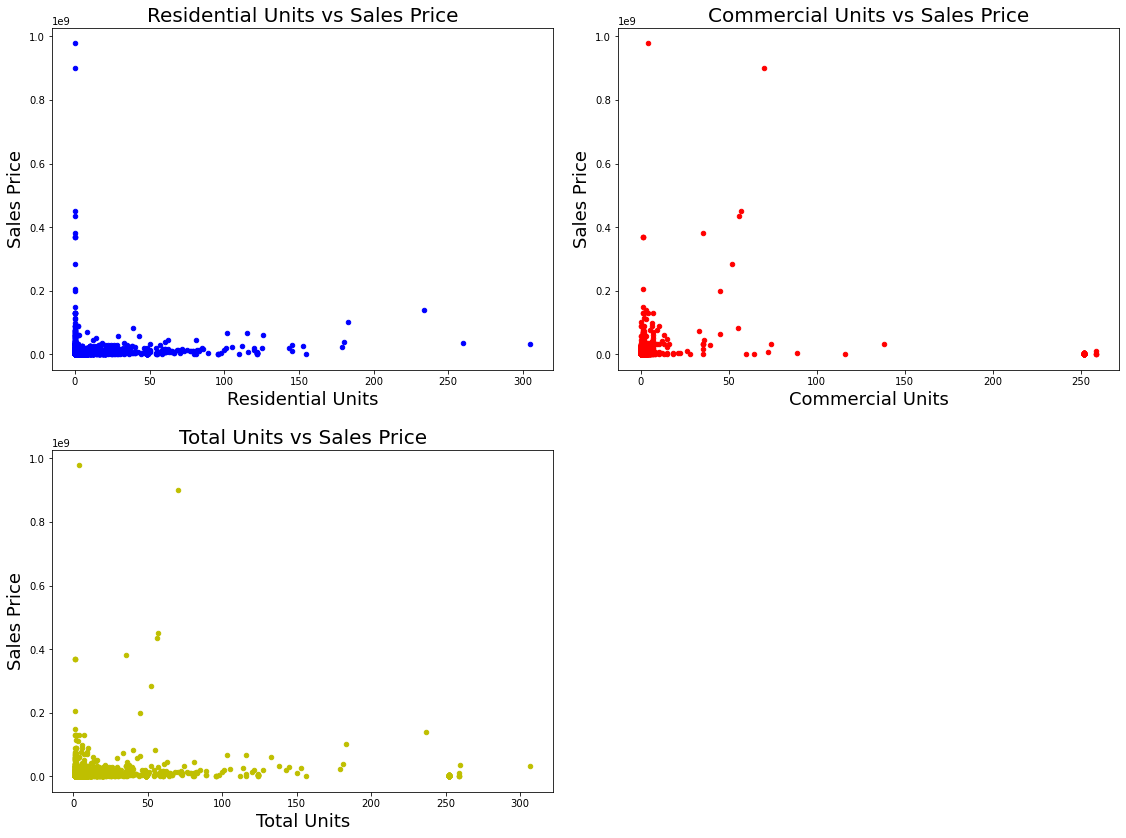

In [15]:
fig = plt.figure(figsize = (16,12))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

ax1.scatter(raw_data['Residential Units'], raw_data['Sales Price'], s=20, c='b')
ax2.scatter(raw_data['Commercial Units'], raw_data['Sales Price'], s=20, c='r')
ax3.scatter(raw_data['Total Units'], raw_data['Sales Price'], s=20, c='y')

ax1.set_title("Residential Units vs Sales Price", size=20)
ax2.set_title("Commercial Units vs Sales Price", size=20)
ax3.set_title("Total Units vs Sales Price", size=20)

ax1.set_xlabel("Residential Units", size=18)
ax1.set_ylabel("Sales Price", size=18);   

ax2.set_xlabel("Commercial Units", size=18)
ax2.set_ylabel("Sales Price", size=18); 

ax3.set_xlabel("Total Units", size=18)
ax3.set_ylabel("Sales Price", size=18); 

plt.tight_layout(pad=2)

#### It appears that the commercial properties are such massive outliers that it's hard to make any observations from the data

There might be a 1/x relationship with Residential Units

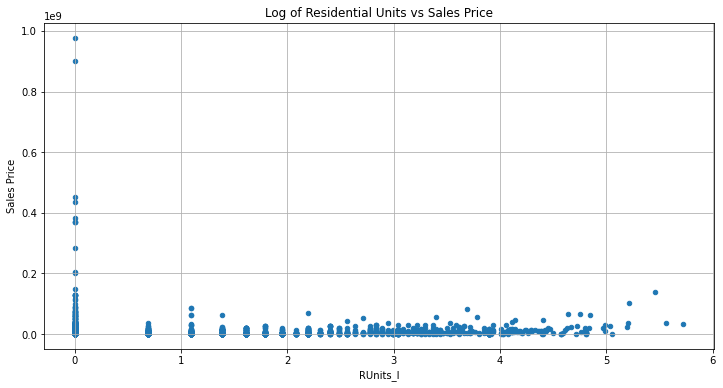

In [16]:
raw_data['RUnits_l'] = np.log(raw_data['Residential Units']+1)
raw_data.plot.scatter(x = 'RUnits_l',
                  y = 'Sales Price',
                  title='Log of Residential Units vs Sales Price',
                  figsize=(12,6),
                  grid=True);

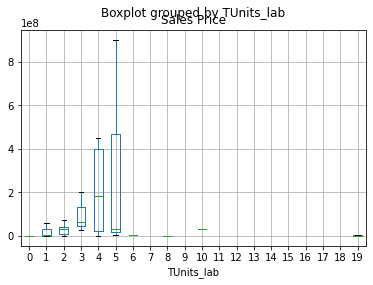

In [17]:
nbins = 20
raw_data['TUnits_lab'] = pd.cut(raw_data['Commercial Units'],bins=nbins, labels = [str(i) for i in range(nbins)])
raw_data.boxplot('Sales Price', by='TUnits_lab', showfliers=False);

There appear to be some heavy outliers, without the extreme outlier, the bins would look completely different, and our analysis would also likely change. 

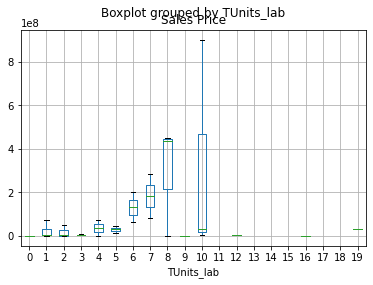

In [18]:
testdf = raw_data[raw_data['Commercial Units'] < 200].copy()

nbins = 20
testdf['TUnits_lab'] = pd.cut(testdf['Commercial Units'].copy() ,bins=nbins, labels = [str(i) for i in range(nbins)])
testdf.boxplot('Sales Price', by='TUnits_lab', showfliers=False);

Excluding the outlier drastically changes the graph. The sharp rise in the first 4 bins is no longer present. Instead, the average sales price doesn't increase until around the fifth box

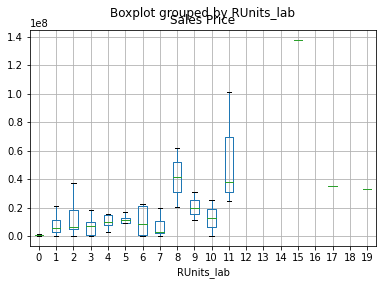

In [19]:
nbins = 20
raw_data['RUnits_lab'] = pd.cut(raw_data['Residential Units'],bins=nbins, labels = [str(i) for i in range(nbins)])
raw_data.boxplot('Sales Price', by='RUnits_lab', showfliers=False);

The residential units have a much clearer trend, and appear to have less drastic outliers than the commercial units vs price graph.

### I have come to the conclusion that it would be difficult to build one model that can accurately make predictions for both the commercial and residential markets; especially without a larger dataset. Going foward, I will only focus on the residential real estate market.

To focus in on the residential real estate market, I will eliminate any buildings with the tax class 4. According to the NYC finance website, tax class 1 & 2 are residential properties and class 4 is commercial properties. I will also remove some building types. These should all be classified as tax class 4, but I want to make sure they are not included. These building classes include golf courses, churches, and parking garages. The full list can be found directly on https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html

In [20]:
raw_data = raw_data[(~raw_data['Building Class'].str.startswith('F')) & (~raw_data['Building Class'].str.startswith('G')) & 
                    (~raw_data['Building Class'].str.startswith('M')) & (~raw_data['Building Class'].str.startswith('P')) & 
                    (~raw_data['Building Class'].str.startswith('T')) & (~raw_data['Building Class'].str.startswith('V')) & 
                    (~raw_data['Building Class'].str.startswith('W')) & (~raw_data['Building Class'].str.startswith('Y')) & 
                    (~raw_data['Building Class'].str.startswith('Z'))] 

In [21]:
raw_data = raw_data[(~raw_data['Description'].str.startswith('27')) & (~raw_data['Description'].str.startswith('29')) &
                    (~raw_data['Description'].str.startswith('30')) & (~raw_data['Description'].str.startswith('36')) & 
                    (~raw_data['Description'].str.startswith('37')) & (~raw_data['Description'].str.startswith('38'))]

In [22]:
data = raw_data[(raw_data['Tax Class'] != 3) & (raw_data['Tax Class'] != 4)].copy()

# We're left with a sample size of 18,386 properties
data.drop(['Block','Lot','Zip Code'], axis=1).describe()

,Tax Class,Residential Units,Commercial Units,Total Units,land sq ft,sq ft,Sales Price,Building Age,sqft_per_unit,RUnits_l
count,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,18386.000000,1.838600e+04,18377.000000,18386.000000,18386.000000
mean,1.074676,2.597629,0.054824,2.652453,3293.703252,4200.196835,1.231245e+06,77.605920,2592.479617,1.006920
std,0.262876,7.999630,0.315732,8.091398,4565.916016,26256.295476,3.148219e+06,31.490366,24771.485250,0.493726
min,1.000000,1.000000,0.000000,1.000000,305.000000,180.000000,3.000000e+04,0.000000,90.000000,0.693147
25%,1.000000,1.000000,0.000000,1.000000,2000.000000,1344.000000,5.400000e+05,60.000000,933.333333,0.693147
50%,1.000000,2.000000,0.000000,2.000000,2500.000000,1806.000000,7.250000e+05,89.000000,1170.000000,1.098612
75%,1.000000,2.000000,0.000000,2.000000,3996.000000,2497.750000,9.950000e+05,100.000000,1482.000000,1.098612
max,2.000000,305.000000,10.000000,307.000000,278400.000000,472115.000000,1.377500e+08,220.000000,472115.000000,5.723585


In [23]:
sqft = data['sq ft']

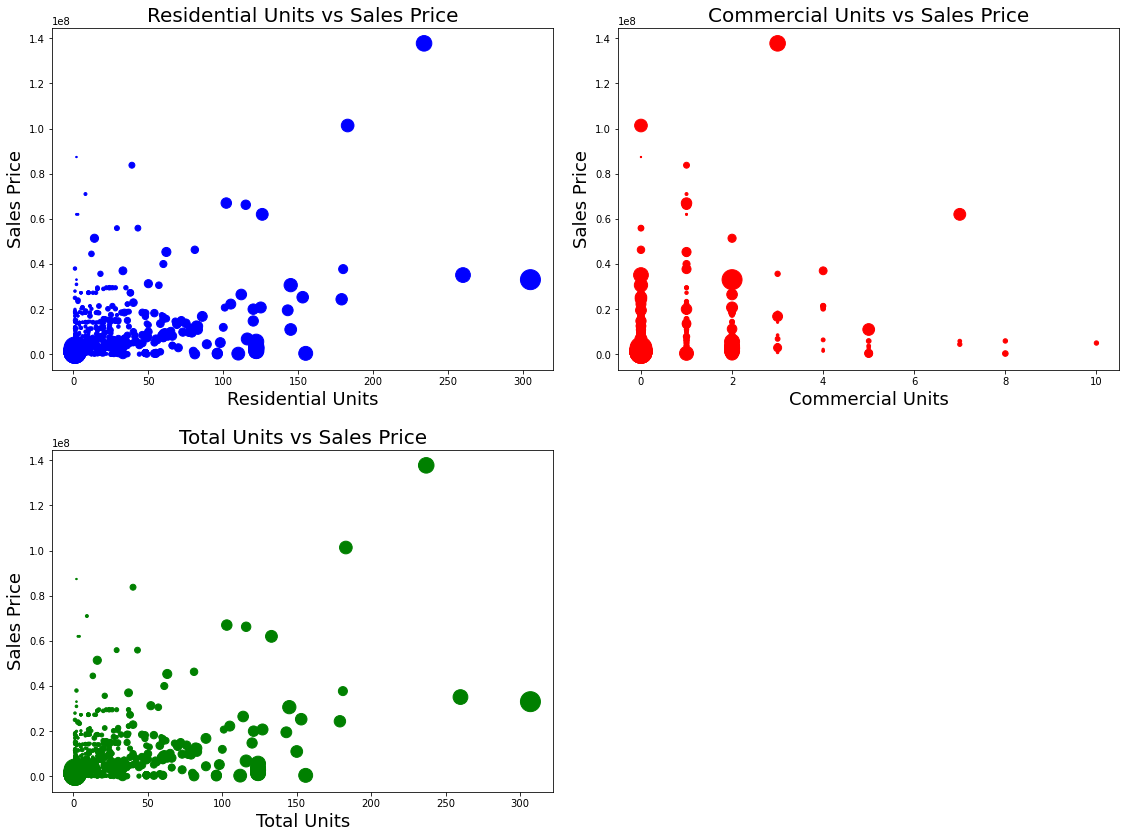

In [24]:
fig = plt.figure(figsize = (16,12))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

ax1.scatter(data['Residential Units'], data['Sales Price'], s=sqft/1000, c='b')
ax2.scatter(data['Commercial Units'], data['Sales Price'], s=sqft/1000, c='r')
ax3.scatter(data['Total Units'], data['Sales Price'], s=sqft/1000, c='g')

ax1.set_title("Residential Units vs Sales Price", size=20)
ax2.set_title("Commercial Units vs Sales Price", size=20)
ax3.set_title("Total Units vs Sales Price", size=20)

ax1.set_xlabel("Residential Units", size=18)
ax1.set_ylabel("Sales Price", size=18);   

ax2.set_xlabel("Commercial Units", size=18)
ax2.set_ylabel("Sales Price", size=18); 

ax3.set_xlabel("Total Units", size=18)
ax3.set_ylabel("Sales Price", size=18); 

plt.tight_layout(pad=2)


There is definetly clearer trends in the units vs price. There seems to be positive association between both residential and total units with price. There seems to be a negative association with commercial units. Also, the residential and total units graphs look extremely similar.

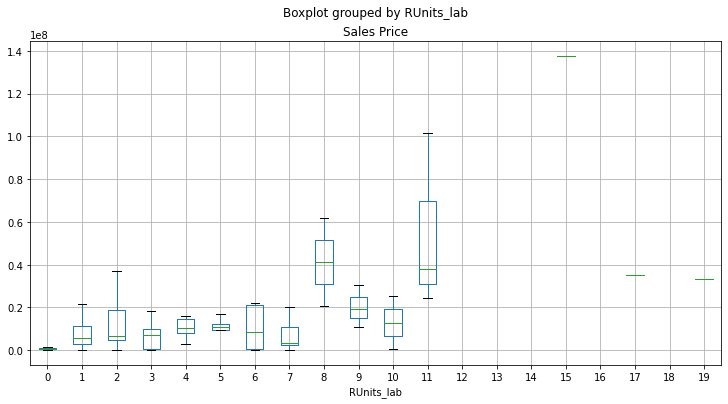

In [25]:
data.boxplot('Sales Price', by='RUnits_lab', showfliers=False, figsize = (12,6));

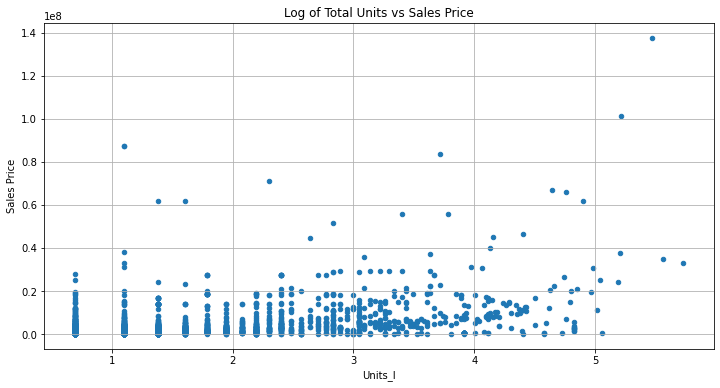

In [26]:
# Create a variable that is the log of the total units
data['Units_l'] = np.log(data['Total Units']+1)
data.plot.scatter(x = 'Units_l',
                  y = 'Sales Price',
                  title='Log of Total Units vs Sales Price',
                  figsize=(12,6),
                  grid=True);


#### It's hard to see any real pattern becuase they seem to be concentrated in the bottom part of the graph, but the outliers expand the graph up.

Maybe a taking a random sample will make it easier to see a pattern

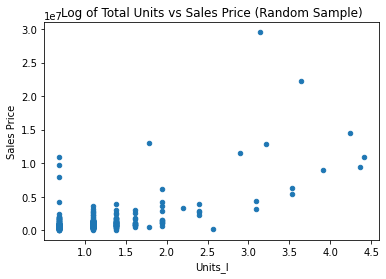

In [27]:
snip = data.iloc[random.sample(range(len(data)),500)]
snip.plot.scatter(x = 'Units_l',
                  y = 'Sales Price',
                  title='Log of Total Units vs Sales Price (Random Sample)');

The data looks clusterd below 2.5 units_l, but then there appears to be a more scattered reltionship beyond that

In [28]:
# Create a variable for the log of Building Age
data['Age_l'] = np.log(data['Building Age'] + 1)

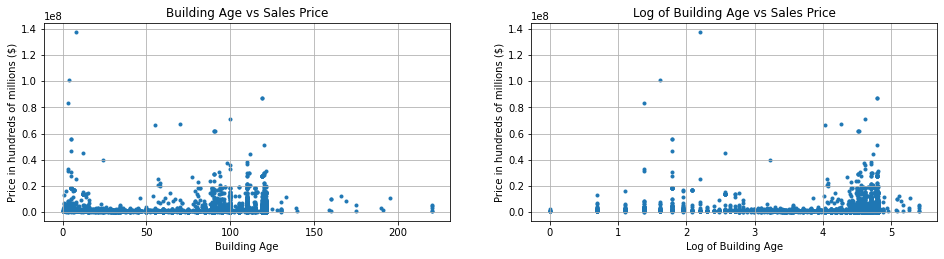

In [29]:
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1.scatter('Building Age','Sales Price',data=data, marker='.')#, s=sqft/1000)
ax2.scatter('Age_l','Sales Price',data=data, marker='.') #, s=sqft/1000)

ax1.set_title('Building Age vs Sales Price')
ax2.set_title('Log of Building Age vs Sales Price');

ax1.set_ylabel('Price in hundreds of millions ($)')
ax2.set_ylabel('Price in hundreds of millions ($)')

ax1.set_xlabel('Building Age')
ax2.set_xlabel('Log of Building Age')

ax1.grid()
ax2.grid()

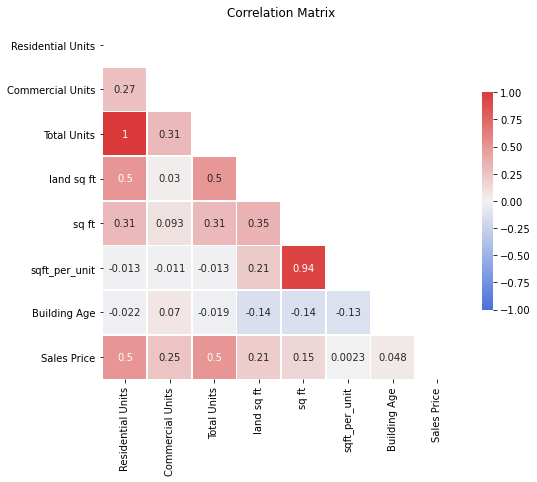

In [30]:
corr = data[['Residential Units','Commercial Units',
           'Total Units', 'land sq ft','sq ft', 'sqft_per_unit', 'Building Age', 'Sales Price']].corr()

# Create a covering for the top of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
plt.title('Correlation Matrix')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(258.6, 12.2, s=75, l=50, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True, center=0,
            square=True, linewidths=.75, cbar_kws={"shrink": .5});


Observations:

- The Residential and Total Units are perfectly correlated, so we will probably want to exclude one of them from the model

- In general, there seems to be a decent bit of correlation between the variables. This could potentially be an issue, as an assumption of linear regression is little to no multicollinearity.

- Sales Price has a .2+ correlation with 4 of our 6 variables

- Building Age's strongest relationship is -.14, but otherwise, it has a mostly neutral relationship with all the variables

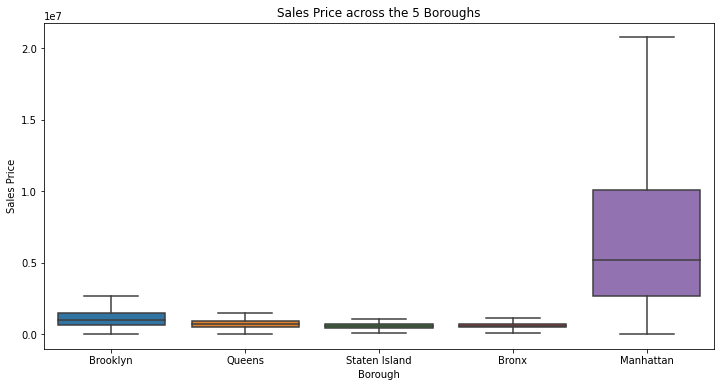

In [31]:
temp = data[['Borough','Sales Price']]
plt.figure(figsize=(12,6))
sns.boxplot(x = temp['Borough'],
             y= temp['Sales Price'],
            showfliers=False).set_title('Sales Price across the 5 Boroughs');

In [32]:
with open('nyc_zip_code_tabulation_areas_polygons.geojson') as file:
    nyc_area = json.load(file)

tempdf = data[['Zip Code', 'Sales Price']].groupby('Zip Code').median()
tempdf.reset_index(inplace=True)
    
nyc_map = folium.Map(location=[40.693943, -73.985880],zoom_start=10)

folium.Choropleth(geo_data=nyc_area, 
                  data= tempdf, 
                  columns=['Zip Code','Sales Price'],
                  key_on= 'feature.properties.postalcode',
                  fill_color='YlOrRd',
                  fill_opacity = .5,
                  line_opacity = .2,
                  nan_fill_color = 'grey',
                  nan_fill_opacity = 1,
                  legend_name= 'Median Sales Price',
                  highlight=True).add_to(nyc_map)

nyc_map

### It looks like downtown Manhatten has the most expensive median sales price by a wide margin. 

NOTE: There is greyed out areas in the Financial District becuase there were only a few residential sales there, and the sq ft numbers were almost never reported with the sale

In [33]:
data.drop(['Block','Lot','Neighborhood','TUnits_lab','RUnits_lab','Description','Address'], axis=1, inplace=True)
#data.dropna(subset=['Building Age'], inplace=True)
data.dropna(inplace=True)

## Modeling

### Model 1

In [34]:
data.reset_index(inplace=True)

In [35]:
X = data.drop('Sales Price', axis=1)
y = data['Sales Price']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

For the first model, I decided to use the four variables that had +.2 correlation with Sales Price. 

In [36]:
columns = ['Commercial Units', 'Residential Units', 'Total Units', 'land sq ft']
X_train = X_train[columns]
X_test = X_test[columns]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [37]:
comparisons = pd.DataFrame()
comparisons['predicted'] = y_pred
comparisons['actual'] = y_test

mae = np.mean((y_pred - y_test)**2)


In [38]:
print('Model r2 Score:', r2_score(y_test,y_pred))
print('Model MAE:', mae)
print('Intercept:', model.intercept_)
print('Coefficeients:', model.coef_)

Model r2 Score: 0.2750964167897111
Model MAE: 4707806479226.552
Intercept: 729023.4442738803
Coefficeients: [ 7.44083929e+05 -2.74642439e+05  4.69441489e+05 -1.73206627e+01]


r2 is pretty low and MAE is ridiculously high

### Model 2

In [39]:
X = data.drop('Sales Price', axis=1)
y = data['Sales Price']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [41]:
# Since total and residential units are perfectly correlated, we will try a model without one of them.
columns = ['Commercial Units', 'Residential Units', 'land sq ft']
X_train = X_train[columns]
X_test = X_test[columns]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [42]:
comparisons = pd.DataFrame()
comparisons['predicted'] = y_pred
comparisons['actual'] = y_test
comparisons
mae = np.mean((y_pred - y_test)**2)

In [43]:
print('Model r2 Score:', r2_score(y_test, y_pred))
print('Model MAE:', mae)
print('Intercept:', model.intercept_)
print('Coefficeients:', model.coef_)

Model r2 Score: 0.275096416789707
Model MAE: 4707806479226.578
Intercept: 729023.4442740086
Coefficeients: [ 1.21352542e+06  1.94799050e+05 -1.73206627e+01]


Maybe this didn't change at all because of the perfect correlation between two of the variables in the first model.

### Model 3

In [44]:
X = data.drop('Sales Price', axis=1)
y = data['Sales Price']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [46]:
columns = ['Commercial Units','Residential Units','sq ft','land sq ft']
X_train = X_train[columns]
X_test = X_test[columns]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [47]:
comparisons = pd.DataFrame()
comparisons['predicted'] = y_pred
comparisons['actual'] = y_test
comparisons
mae = np.mean((y_pred - y_test)**2)

In [48]:
print('Model r2 Score:', r2_score(y_test, y_pred))
print('Model MAE:', mae)
print('Intercept:', model.intercept_)
print('Coefficeients:', model.coef_)

Model r2 Score: 0.2746654824919178
Model MAE: 4710605134559.851
Intercept: 716171.079182398
Coefficeients: [ 1.21902428e+06  1.95417060e+05 -1.44567962e+00 -1.21045776e+01]


A little worse than before.

## Model 4

In [49]:
X = data.drop('Sales Price', axis=1)
y = data['Sales Price']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [50]:
columns = ['Commercial Units','Residential Units', 'sq ft','land sq ft', 'Building Age']
X_train = X_train[columns]
X_test = X_test[columns]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [51]:
comparisons = pd.DataFrame()
comparisons['predicted'] = y_pred
comparisons['actual'] = y_test
mae = np.mean((y_pred - y_test)**2)

In [52]:
print('Model r2 Score:', r2_score(y_test, y_pred))
print('Model MAE:', mae)
print('Intercept:', model.intercept_)
print('Coefficeients:', model.coef_)

Model r2 Score: 0.2766680291308672
Model MAE: 4697599815976.598
Intercept: 272363.5194424918
Coefficeients: [ 1.17610276e+06  1.94668084e+05 -7.88510209e-01 -5.03264150e+00
  5.43409489e+03]


### Model 5

In [53]:
X = data.drop('Sales Price', axis=1)
y = data['Sales Price']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

In [55]:
# Instead of building age lets try the log of Age
columns = ['Commercial Units','Residential Units', 'sq ft','land sq ft', 'Age_l']
X_train = X_train[columns]
X_test = X_test[columns]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [56]:
comparisons = pd.DataFrame()
comparisons['predicted'] = y_pred
comparisons['actual'] = y_test
comparisons
mae = np.mean((y_pred - y_test)**2)

In [57]:
print('Model r2 Score:', r2_score(y_test, y_pred))
print('Model MAE:', mae)
print('Intercept:', model.intercept_)
print('Coefficeients:', model.coef_)

Model r2 Score: 0.27441529280717447
Model MAE: 4712229963911.168
Intercept: 427057.1078622922
Coefficeients: [ 1.21005289e+06  1.95321571e+05 -1.08431161e+00 -1.05049764e+01
  6.75671200e+04]


It looks like normal building age preforms slightly better than the log of age

### Model 6

In [58]:
# Create a variable for the sqft/ unit
data['sq ft per Res Unit'] = data['sq ft'] / data['Residential Units']

data.replace(np.inf,0,inplace=True)
data.replace(np.nan,0,inplace=True)

In [59]:
X = data.drop('Sales Price', axis=1)
y = data['Sales Price']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [60]:
columns = ['Residential Units', 'Commercial Units', 'sq ft', 'land sq ft', 'Building Age', 'sq ft per Res Unit']
X_train = X_train[columns]
X_test = X_test[columns]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [61]:
comparisons = pd.DataFrame()
comparisons['predicted'] = y_pred
comparisons['actual'] = y_test
mae = np.mean((y_pred - y_test)**2)

In [62]:
print('Model r2 Score:', r2_score(y_test, y_pred))
print('Model MAE:', mae)
print('Intercept:', model.intercept_)
print('Coefficeients:', model.coef_)

Model r2 Score: 0.21548796890366972
Model MAE: 5094926978661.503
Intercept: 101690.04767569504
Coefficeients: [ 4.07633721e+05  1.39507700e+06 -1.97183680e+02 -3.07767161e+00
  4.22459385e+03  1.99420233e+02]


### Model 7

In [63]:
# Create dummy variables for the 5 boroughs
data = pd.get_dummies(data,columns=['Borough'],drop_first=False,prefix='', prefix_sep='')

In [64]:
X = data.drop('Sales Price', axis=1)
y = data['Sales Price']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [65]:
columns = ['Residential Units', 'sq ft', 'land sq ft', 'Building Age',
           'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

X_train = X_train[columns]
X_test = X_test[columns]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [66]:
comparisons = pd.DataFrame()
comparisons['predicted'] = y_pred
comparisons['actual'] = y_test
mae = np.mean((y_pred - y_test)**2)

In [67]:
print('Model r2 Score:', r2_score(y_test, y_pred))
print('Model MAE:', mae)
print('Intercept:', model.intercept_)
print('Coefficeients:', model.coef_)

Model r2 Score: 0.3582538125428544
Model MAE: 4167749931584.0225
Intercept: 1466018.7540375036
Coefficeients: [ 1.77110630e+05 -3.39936782e+00  1.94139940e+01  9.35473437e+01
 -1.09378020e+06 -3.68404353e+05  3.61834136e+06 -9.86315956e+05
 -1.16984085e+06]


### Model 8

In [68]:
X = data.drop(['Sales Price'], axis=1)
y = data['Sales Price']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [69]:
columns = ['Residential Units', 'Commercial Units', 'land sq ft', 'sq ft', 'Building Age', 
          'sq ft per Res Unit', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

X_train = X_train[columns]
X_test = X_test[columns]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [70]:
comparisons = pd.DataFrame()
comparisons['predicted'] = y_pred
comparisons['actual'] = y_test
mae = np.mean((y_pred - y_test)**2)

In [71]:
print('Model r2 Score:', r2_score(y_test, y_pred))
print('Model MAE:', mae)
print('Intercept:', model.intercept_)
print('Coefficeients:', model.coef_)

Model r2 Score: 0.31240709538850864
Model MAE: 4465496386518.963
Intercept: 1199905.954573672
Coefficeients: [ 3.74400622e+05  9.51370027e+05  2.81375839e+01 -1.92061335e+02
 -1.21567311e+03  1.91204998e+02 -1.00315399e+06 -2.99555097e+05
  3.28415952e+06 -8.96732703e+05 -1.08471773e+06]


### Model 7 worked the best.

In [72]:
data = sm.add_constant(data[['Residential Units', 'sq ft', 'land sq ft', 'Building Age',
           'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Sales Price']])

X = data.drop('Sales Price', axis=1)
y = data['Sales Price']

reg = sm.OLS(y, X).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:            Sales Price   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     1008.
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:50:02   Log-Likelihood:            -2.9759e+05
No. Observations:               18377   AIC:                         5.952e+05
Df Residuals:                   18368   BIC:                         5.953e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.247e+06   5.76e+0